실행시간 계산 클래스

In [17]:
from time import *

class TimeCheck :
    def __init__(self, func) :
        self.func = func
    
    def __call__(self, *x_func) :
        start_tm = time() ; start_ltm = localtime(start_tm)
        prt_start = strftime("[%Y-%m-%d %H:%M]", start_ltm)
        print(prt_start)
        
        self.func(*x_func)
        
        fin_tm = time()
        spent_tm = fin_tm - start_tm
        print('\n코드의 실행시간은: %f'%spent_tm)

코드1 : 데이터 정리 및 분석 1 - Excel 파일 열고 기본 데이터 추출하는 클래스

In [18]:
import pandas as pd
import numpy as np
import openpyxl as opxl

class OpenData :
    def __init__(self, excel) :
        """Excel 파일 열기 및 기본 데이터 추출"""
        #Excel 파일 열기
        self.excel = excel
        self.rawfile = opxl.load_workbook(self.excel)
        self.editfile = self.rawfile.active
        
        #기본 데이터 추출
        self.dataset = self.allDataList()
        self.country_list, self.country_num = self.countrylist()
        self.time_list = self.timelist()
        self.ana_list = self.realdata()
        self.df = self.makeDataFrame()
        self.data_dict = self.realdata_dict()
        
    def allDataList(self) :
        """열린 Excel 파일을 row 기준으로 읽어 한 리스트에 저장"""
        dataset = []
        
        for row_n in self.editfile.rows :
            row_data = []
            
            for cell in row_n :
                row_data.append(cell.value)
                while True :
                    if None in row_data :
                        row_data.remove(None)
                    else :
                        break
            
            dataset.append(row_data)
        
        return dataset

    def countrylist(self) :
        """분석가능 여부와 상관없이 데이터가 있는 국가 리스트 산출"""
        country_candidate = list(self.editfile.columns)[0]
        country_list = []
        country_start = False; country_end = False
        
        for cn in country_candidate :
            if cn.value == 'Country' :
                country_start = True
            if 'Data extracted' in cn.value :
                country_end = True
            
            if country_end == True :
                break
            
            if country_start == True :
                country_list.append(cn.value)
            else : 
                continue
            
        country_list.remove('Country')
        
        return country_list, len(country_list)
    
    def timelist(self) :
        """분석가능 여부와 상관없이 데이터가 있는 기간 리스트 산출"""
        time_list = []
        
        for row_t in self.dataset :
            if 'Time' in row_t :
                for tl in range(1, len(row_t)) :
                    time_list.append(row_t[tl])
        
        return time_list
    
    def realdata(self) :
        """실제로 분석하고자 하는 data를 row 기준으로 list로 저장"""
        ana_list = []
        
        for row_a in self.dataset :
            if set(row_a) & set(self.country_list) != set() :
                del row_a[0:2]
                if 'i' in row_a :
                    row_a.remove('i')
                ana_list.append(row_a)
        
        return ana_list
    
    def realdata_dict(self) :
        """국가 별로 데이터 정리하여 dictionary로 저장"""
        data_dict = {}
        for z in range(len(self.ana_list)) :
            data_dict[self.country_list[z]] = self.ana_list[z]
        
        return data_dict
            
    
    def makeDataFrame(self) :
        """맞게 정리되었는지 검토하기 위해 dataframe 형식으로 확인"""
        df_xl = pd.DataFrame(self.ana_list,
                             index = self.country_list,
                             columns = self.time_list)
        
        return df_xl

코드1 : 데이터 정리 및 분석 2 - 기본 통계 정보 계산 클래스 (1집단)

In [19]:
import math as mt

class BasicStat_1(OpenData) :
    def __init__(self, data) :
        "한 종류의 통계 자료로부터 얻을 수 있는 기본 통계 정보를 dictionary로 저장"
        #통계 자료
        self.data = data
        
        #통계 정보
        self.mean = self.mean_list()
        self.stdev = self.stdev_list()
    
    def mean_list(self) :
        """국가별 평균을 계산하여 dictionary로 저장"""
        #평균 구하기
        mean_l = [] ; mean = 0
        for cd in self.data.ana_list :
            for x in cd :
                if x != '..' :
                    mean += x
                else :
                    continue
            
            mean = mean/(len(cd)-cd.count('..'))
            mean_l.append(mean)
            
        
        #사전에 저장하기
        mean_dict = {}
        for z in range(len(self.data.country_list)) :
            mean_dict[self.data.country_list[z]] = mean_l[z]
        
        return mean_dict
            
        
    def stdev_list(self) :
        """국가별 표준편차를 계산하여 dictionary로 저장"""
        #표준편차 구하기
        stdev_l = [] ; stdev = 0
        for cd in range(len(self.data.ana_list)) :
            for y in range(len(self.data.ana_list[cd])) :
                if self.data.ana_list[cd][y] != '..' :
                    stdev += (self.data.ana_list[cd][y]-self.mean[self.data.country_list[cd]])**2
                else :
                    continue
            
            stdev = stdev/(len(self.data.ana_list[cd])-self.data.ana_list[cd].count('..'))
            stdev = mt.sqrt(stdev)
            stdev_l.append(stdev)
                      
        #사전에 저장하기
        stdev_dict = {}
        for z in range(len(self.data.country_list)) :
            stdev_dict[self.data.country_list[z]] = stdev_l[z]
        
        return stdev_dict

코드1 : 데이터 정리 및 분석 3 - 기본 통계 정보 계산 클래스 (2집단)

In [20]:
import math as mt
import numpy as np

def inter(list1, list2) :
    """두 리스트의 교집합과 대칭차집합을 구해주는 함수"""
    i_list = list(set(list1) & set(list2)) #&는 교집합
    n_list = list(set(list1) ^ set(list2)) #^는 대칭차집합
    
    return i_list, n_list

class BasicStat_2(OpenData) :
    def __init__(self, data1, data2, stat1, stat2) :
        """두 종류의 통계 자료로부터 얻을 수 있는 기본 통계 정보를 dictionary로 저장"""
        #통계 자료
        self.data1 = data1
        self.data2 = data2
        self.stat1 = stat1
        self.stat2 = stat2
        
        #통계 정보
        self.inter_country, self.non_country = self.country_inter_test()
        self.corr = self.corr_list()
        self.trend = self.co_trend()
        
    def country_inter_test(self) :
        """두 개의 통계 자료 모두에 같은 국가 데이터가 존재하는지 검사"""
        #inter_list는 국가가 두 데이터에 모두 존재하는 경우, non_list는 국가명이 중복되지 않는 경우
        inter_list, non_list = inter(self.data1.country_list, self.data2.country_list)
        
        return inter_list, non_list
        
    def corr_list(self) :
        """국가별 두 통계 자료의 상관계수를 계산하여 dictionary로 저장 : 두 데이터 모두 있는 국가에 한하여"""
        #상관계수 구하기
        corr_l = []; corr = 0
        for cn in self.inter_country :
            for cd in range(len(self.data1.time_list)) :
                if (self.data1.data_dict[cn][cd] != '..' and self.data2.data_dict[cn][cd] != '..') :
                    corr += (self.data1.data_dict[cn][cd] - self.stat1.mean[cn])*(self.data2.data_dict[cn][cd] - self.stat2.mean[cn])
            
            corr = corr/(len(self.data1.data_dict[cn]))
            corr = corr/(self.stat1.stdev[cn] * self.stat2.stdev[cn])
            
            corr_l.append(corr)
        
        #사전에 저장하기
        corr_dict = {}
        for z in range(len(self.inter_country)) :
            corr_dict[self.inter_country[z]] = corr_l[z]
        
        return corr_dict
    
    def co_trend(self) :
        """국가별 두 통계 자료의 2차 추세선의 계수를 계산하여 dictionary로 저장 : 두 데이터 모두 있는 국가에 한하여"""
        #추세선 구하기
        trend_l = []
        for cn in self.inter_country :
            rur = RUR.data_dict[cn][:] ; jv = JV.data_dict[cn][:] #data_dict 값 불변을 위한 복사
            rur_d = [] ; jv_d = [] #두 데이터 모두 있는 기간에만 append
            for i in range(len(rur)) : #len(rur) == len(jv) > 동일 기간 관측 자료이기 때문
                if (rur[i] != '..') and (jv[i] != '..') :
                    rur_d.append(rur[i])
                    jv_d.append(jv[i])
                else :
                    continue
            
            rur_corr = np.array(rur_d); jv_corr = np.array(jv_d)
            trend = np.polyfit(rur_corr, jv_corr, 2) #2차 다항식 근사
            
            trend_l.append(trend)
        
        #사전에 저장하기
        trend_dict = {}
        for z in range(len(self.inter_country)) :
            trend_dict[self.inter_country[z]] = trend_l[z]
        
        return trend_dict

코드2 : 데이터 저장 및 호출 1 - 데이터 저장 클래스

In [21]:
@TimeCheck
class SaveData :
    def __init__(self, dt1, dt2, st1, st2, st12) :
        self.dt1 = dt1; self.dt2 = dt2
        self.st1 = st1; self.st2 = st2
        self.st12 = st12
        
        #텍스트 파일 열기
        self.save = open("SaveData.txt", "wt")
        
        #저장1(국가 리스트 저장)
        self.save.write("'%s' 파일과 '%s' 파일을 정리한 데이터 파일입니다.\n"%(self.dt1.excel, self.dt2.excel))
        self.save.write("|\n")
        self.save.write("실업률 분석 가능 국가 리스트 : %s\n"%self.dt1.country_list)
        self.save.write("구인율 분석 가능 국가 리스트 : %s\n"%self.dt2.country_list)
        self.save.write("Beveridge Curve 분석 가능 국가 리스트 : %s\n"%self.st12.inter_country)
        
        #저장2(반복문으로 개별 국가 저장)
        self.save.write("----------------------------------------\n")
        for cn in sorted(list(set(self.dt1.country_list)|set(self.dt2.country_list))) :
            if cn in self.st12.inter_country :
                self.save_info(cn)
                self.save.write("|\n")
                self.save_stat1(cn)
                self.save.write("|\n")
                self.save_stat2(cn)
            else :
                self.save_info(cn)
                self.save.write("|\n")
                self.save_stat1(cn)
            self.save.write("----------------------------------------\n")
        
        #저장 종료 및 텍스트 파일 닫기
        self.save.write("\n-End of the SaveData.txt-")
        print("데이터 저장이 완료되었습니다. SaveData.txt에서 확인할 수 있습니다.")
        self.save.close()
        
    def save_info(self, country) :
        """해당 국가에 대한 기본적인 정보 저장"""
        self.save.write("%s에 대한 기본 정보입니다.\n"%country)
        self.save.write("국가명 : %s\n"%country) #국가명 저장
        if country in self.dt1.country_list : #실업률 통계가 있을 경우
            self.save.write("%s의 월별 실업률 데이터(2000.JAN. - 2020.MAY.)\n%s\n"%(country, self.dt1.data_dict[country]))
        if country in self.dt2.country_list : #구인율 통계가 있을 경우
            self.save.write("%s의 월별 구인율 데이터(2000.JAN. - 2020.MAY.)\n%s\n"%(country, self.dt2.data_dict[country]))
    
    def save_stat1(self, country) :
        """해당 국가에 대한 1집단 통계 저장"""
        if country in self.dt1.country_list : #실업률 통계가 있을 경우
            self.save.write("%s의 실업률 평균 : %f\n"%(country, self.st1.mean[country]))
            self.save.write("%s의 실업률 표준편차 : %f\n"%(country, self.st1.stdev[country]))
        if country in self.dt2.country_list : #구인율 통계가 있을 경우
            self.save.write("%s의 구인율 평균 : %f\n"%(country, self.st2.mean[country]))
            self.save.write("%s의 구인율 표준편차 : %f\n"%(country, self.st2.stdev[country]))
    
    def save_stat2(self, country) :
        """해당 국가에 대한 2집단 통계 저장"""
        self.save.write("%s의 실업률과 구인율 상관계수 : %f\n"%(country, self.st12.corr[country]))
        self.save.write("%s의 실업률과 구인율 2차 추세선 계수 : %s\n"%(country, list(self.st12.trend[country])))

코드2 : 데이터 저장 및 호출 2 - 입력 및 데이터 호출 클래스

In [22]:
import re

class InputError(Exception) :
    def __init__(self, msg) :
        self._message = msg

class UserInputAndCall :
    def __init__(self, dt1, dt2, st1, st2, st12) :
        self.dt1 = dt1; self.dt2 = dt2
        self.st1 = st1; self.st2 = st2
        self.st12 = st12
        
        input_st1 = False; input_st2 = False
        
        #입력 : 입력값 상태가 True가 될 때까지 반복
        ##비교하고자 하는 국가 개수 입력
        while input_st1 == False :
            try :
                self.n = self.userinput_n()
            except InputError as e :
                print(e.args[0])
                continue
            except ValueError :
                print("국가의 개수는 하나의 자연수로 표현되어야 합니다.")
                continue
            else :
                print("%d 개 국가를 입력하셨습니다."%self.n)
                print("----------------------------------------\n")
                input_st1 = True
        
        ##비교하고자 하는 국가 이름 입력
        while input_st2 == False :
            try :
                self.cn = self.userinput_cn(self.num)
            except InputError as e :
                print(e.args[0])
                continue
            else :
                print("%s 의 Beveridge Curve 분석을 시작합니다."%self.cn)
                input_st2 = True

        #호출
        self.call = self.datacall(self.cn)
    
    def userinput_n(self) :
        """사용자가 비교하고자 하는 국가의 개수 입력받음"""
        print('-------------------------------------------')
        print("분석하고자 하는 국가의 개수를 입력해주세요.")
        print("%s, %s 파일을 분석한 결과 Beveridge Curve 분석은 최대 %d 개국이 가능합니다."%(self.dt1.excel, self.dt2.excel, len(self.st12.inter_country)))
        print("|")
        self.num = input("개수 : ")
        print("|")
        self.num = int(self.num)
        
        if self.num <= 0 :
            raise InputError("국가의 개수는 자연수여야 합니다.")
        
        elif self.num > len(self.st12.inter_country) :
            raise InputError("최대 분석가능 국가 개수는 %d 개입니다."%len(self.st12.inter_country))
            
        else :
            return self.num
    
    def userinput_cn(self, n) :
        """사용자가 비교하고자 하는 국가 명 입력받음"""
        print("분석하고자 하는 국가 명을 사전에 입력한 개수에 맞게 입력해주세요.(각 국가를 '/'로 구분해주세요)")
        print("%s, %s 파일을 분석한 결과 Beveridge Curve 분석은 %s 가 가능합니다."%(self.dt1.excel, self.dt2.excel, self.st12.inter_country))
        print("|")
        country_name = input("국가 명 : ").split("/")
        print("----------------------------------------\n")
        
        if len(country_name) != n :
            raise InputError("사전에 입력한 개수에 맞게 국가명을 입력하셔야 합니다")
        
        elif len(country_name) == n :
            for cn in country_name :
                if cn not in self.st12.inter_country :
                    raise InputError("분석 대상에 해당하지 않은 국가가 있습니다. 가능 국가 리스트를 다시 확인해 주세요.")
            
        return country_name
    
    def datacall(self, country_list) :
        """사용자가 입력한 정보를 바탕으로 'SaveData.txt'에서 plot에 필요한 정보 호출"""
        call_dict = {}
        
        #SaveData.txt 열기
        call = open("SaveData.txt", "rt")
        data_str = call.read()
        
        #파일에서 필요한 데이터 긁어오기
        for cn in country_list :
            info_dict = {}
            
            comp_test_data = re.compile(r"%s의 월별 (실업률|구인율).*?\n(.+)"%cn, re.I) #국가 기본 데이터
            comp_test_stat1 = re.compile(r"%s의 (실업률|구인율)\s(평균|표준편차)\s[:]\s(\d+[.]*\d*)"% cn, re.I) #국가 1집단 통계
            comp_test_stat2 = re.compile(r"%s의 실업률과 구인율 (상관계수|2차 추세선 계수)\s[:]\s(.*)"%cn, re.I) #국가 2집단 통계
            
            data_find = comp_test_data.findall(data_str) #국가 기본 데이터 모두 찾아 list 형태로 저장
            stat1_find = comp_test_stat1.findall(data_str) #국가 1집단 통계 모두 찾아 list 형태로 저장
            stat2_find = comp_test_stat2.findall(data_str) #국가 2집단 통계 모두 찾아 list 형태로 저장
            
            #data_find를 info_dict에 저장
            for data_tuple in data_find :
                data_l = data_tuple[1] #데이터가 문자열 형태로 저장되어 있음 -> 리스트 형태로 바꿔줘야 함
                
                makelist_p1 = re.compile(r"(\d+[.]*\d*|[.][.]|[-]\d+[.]*\d*)")
                makelist_m1 = makelist_p1.findall(data_l)
                
                for xx in makelist_m1 :
                    if xx == '..' :
                        continue
                    else :
                        makelist_m1[makelist_m1.index(xx)] = float(xx)
                
                info_dict[data_tuple[0]+' 데이터'] = makelist_m1
            
            #stat1_find를 info_dict에 저장
            for stat1_tuple in stat1_find :
                info_dict[stat1_tuple[0]+'의 '+stat1_tuple[1]] = float(stat1_tuple[2])
            
            #stat2_find를 info_dict에 저장
            for stat2_tuple in stat2_find :
                if stat2_tuple[0] == '상관계수' :
                    info_dict[stat2_tuple[0]] = float(stat2_tuple[1])
                if stat2_tuple[0] == '2차 추세선 계수' :
                    stat_l = stat2_tuple[1]
                    
                    makelist_p2 = re.compile(r"(\d+[.]\d+|[-]\d+[.]\d+)")
                    makelist_m2 = makelist_p2.findall(stat_l)
                    
                    corr_list = list(map(float, makelist_m2))
                
                    info_dict[stat2_tuple[0]] = corr_list
            
            #호출한 데이터 call_dict에 저장
            call_dict[cn] = info_dict
        
        #SaveData.txt 닫기
        call.close()
        
        return call_dict

코드3 : 데이터 시각화 - 데이터 시각화 클래스

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

@TimeCheck
class Visual :
    def __init__(self, call, country_list) :
        """Seaborn 라이브러리를 이용하여 원하는 국가와 개수만큼 Beveridge Curve 시각화"""
        self.call = call #self.call = {국가명 : {(실업률|구인율)데이터, 1집단통계, 2집단통계}}
        self.country_list = country_list #사용자가 호출하고자 하는 국가의 리스트
        
        self.fig, self.axes = plt.subplots(nrows = len(self.country_list), figsize=(10, len(self.country_list)*10))

        self.fig.suptitle("<Beveridge Curve Check>", y = 1.03, fontsize = 20, ha = 'center')
        
        for i_cn in range(len(self.country_list)) :
            cn = self.country_list[i_cn]
            self.rur, self.jv = self.clean_data(cn)
            self.data_plot(i_cn, self.rur, self.jv)
        
        self.fig.tight_layout()
        
        self.fig.savefig("Beveridge_Curve_Test.png")
        print("결과 화면 캡처를 'Beveridge_Curve_Test.png'에서 확인하실 수 있습니다.")
        
    def clean_data(self, cn) :
        """데이터가 없는 시기는 plot에서 제외"""
        rur = self.call[cn]["실업률 데이터"][:]; jv = self.call[cn]["구인율 데이터"][:]
        rur_clean = []; jv_clean = []
        
        for i in range(len(rur)) : #len(rur) == len(jv) : 동일 기간 관측 자료이기 때문
            if (rur[i] != '..') and (jv[i] != '..') :
                rur_clean.append(rur[i])
                jv_clean.append(jv[i])
            else :
                continue
        
        rur_clean = np.array(rur_clean); jv_clean = np.array(jv_clean)
        
        return rur_clean, jv_clean
    
    def data_plot(self, i_cn, X_rur, Y_jv) :
        """Scatter Plot 및 추세선 그리기"""
        corr = self.call[self.country_list[i_cn]]["상관계수"]
        
        plot_dict = {'RUR' : X_rur, 'JV' : Y_jv}
        df_XY = pd.DataFrame(plot_dict, columns = ["RUR", "JV"])
        
        mean_X = self.call[self.country_list[i_cn]]["실업률의 평균"]
        mean_Y = self.call[self.country_list[i_cn]]["구인율의 평균"]
        
        X_reg = np.linspace(min(X_rur), max(X_rur), 500)
        
        if len(self.country_list) == 1 :
            plt.plot(df_XY["RUR"], df_XY["JV"], marker = '+', color = 'lightgray',label = "Data", lw = 3, ms=10)
            plt.scatter(mean_X, mean_Y, color = 'y', label = "Mean Value", lw = 10, marker = '+')
            plt.xlabel("Employment Rate")
            plt.ylabel("Vacancy Rate")
            plt.title(self.country_list[i_cn]+" (r : %f)"%corr)
        
            reg = self.call[self.country_list[i_cn]]["2차 추세선 계수"][0] * (X_reg**2) + self.call[self.country_list[i_cn]]["2차 추세선 계수"][1] * X_reg + self.call[self.country_list[i_cn]]["2차 추세선 계수"][2]
            plt.plot(X_reg, reg, color = 'r', label = "Regression", lw = 1)
        
            plt.legend(loc=0)
            plt.rc('axes', titlesize=15)
            plt.grid(True)
        else :
            self.axes[i_cn].plot(df_XY["RUR"], df_XY["JV"], marker = '+', color = 'lightgray', label = "Data", lw = 3, ms=10)
            self.axes[i_cn].scatter(mean_X, mean_Y, color = 'y', label = "Mean Value", lw = 10, marker = '+')
            self.axes[i_cn].set(xlabel = "Employment Rate", ylabel = "Vacancy Rate", title = self.country_list[i_cn]+" (r : %f)"%corr)
            
            reg = self.call[self.country_list[i_cn]]["2차 추세선 계수"][0] * (X_reg**2) + self.call[self.country_list[i_cn]]["2차 추세선 계수"][1] * X_reg + self.call[self.country_list[i_cn]]["2차 추세선 계수"][2]
            self.axes[i_cn].plot(X_reg, reg, color = 'r', label = "Regression", lw = 1)
        
            self.axes[i_cn].legend(loc=0)
            plt.rc('axes', titlesize=15)
            self.axes[i_cn].grid(True)

결과 실행 프로그램

[2020-06-29 21:34]
데이터 저장이 완료되었습니다. SaveData.txt에서 확인할 수 있습니다.

코드의 실행시간은: 0.008975
-------------------------------------------
분석하고자 하는 국가의 개수를 입력해주세요.
.\Registered_Unemployment_Rate.xlsx, .\Job_Vacancies.xlsx 파일을 분석한 결과 Beveridge Curve 분석은 최대 9 개국이 가능합니다.
|
개수 : 9
|
9 개 국가를 입력하셨습니다.
----------------------------------------

분석하고자 하는 국가 명을 사전에 입력한 개수에 맞게 입력해주세요.(각 국가를 '/'로 구분해주세요)
.\Registered_Unemployment_Rate.xlsx, .\Job_Vacancies.xlsx 파일을 분석한 결과 Beveridge Curve 분석은 ['United Kingdom', 'Belgium', 'Czech Republic', 'Germany', 'Austria', 'Switzerland', 'Norway', 'Luxembourg', 'Poland'] 가 가능합니다.
|
국가 명 : United Kingdom/Belgium/Czech Republic/Germany/Austria/Switzerland/Norway/Luxembourg/Poland
----------------------------------------

['United Kingdom', 'Belgium', 'Czech Republic', 'Germany', 'Austria', 'Switzerland', 'Norway', 'Luxembourg', 'Poland'] 의 Beveridge Curve 분석을 시작합니다.
[2020-06-29 21:34]
결과 화면 캡처를 'Beveridge_Curve_Test.png'에서 확인하실 수 있습니다.

코드의 실행시간은: 1.211352
분석을 종료합니다.


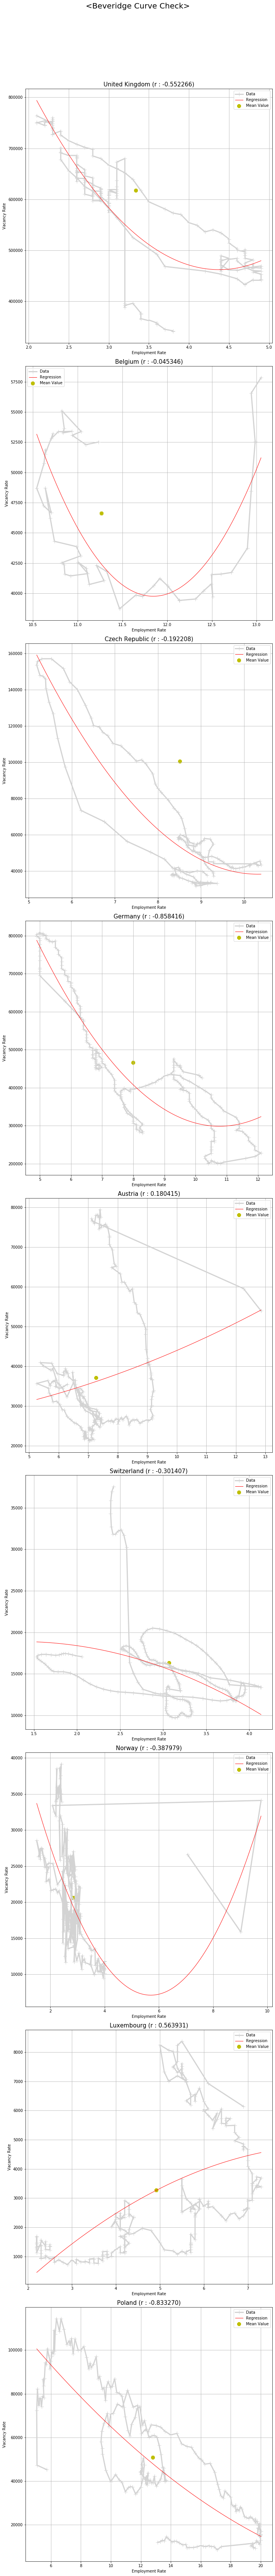

In [16]:
if __name__ == "__main__" :
    #[데이터 정리 및 분석]
    RUR = OpenData('.\Registered_Unemployment_Rate.xlsx')
    JV = OpenData('.\Job_Vacancies.xlsx')
    RUR_stat1 = BasicStat_1(RUR); JV_stat1 = BasicStat_1(JV)
    RV_stat2 = BasicStat_2(RUR, JV, RUR_stat1, JV_stat1)
    
    #[데이터 저장]
    savedata = SaveData(RUR, JV, RUR_stat1, JV_stat1, RV_stat2)

    #[사용자 입력 및 시각화]
    input_call = UserInputAndCall(RUR, JV, RUR_stat1, JV_stat1, RV_stat2)
    visual = Visual(input_call.call, input_call.cn)
    
    print("분석을 종료합니다.")